In [2]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

----
### Step 1: load datasets

- coordinates_book(used): the center of population of each municipality
- out_commuters_book(used): number of out-commuters of each municipality
- workers_by_home_municipality_book(used): number of workers living in each municipality
- jobs_in_each_municipality_book(used): number of jobs located in each municipality
- tessellation(used): spatial information of each municipality, for calculating the average area $<S>$

In [3]:
tessellation = gpd.read_file('./data/finland-municipalities-topojson.geojson').rename(columns={'id': 'tile_ID'})

dict_change_name = {
    'Inkoo':'Ingå',
    'Koski Tl':'Koski_Tl',
    'Kristiinankaupunki':'Kristinestad',
    'Kruunupyy':'Kronoby',
    'Luoto':'Larsmo',
    'Maalahti':'Malax',
    'Maarianhamina':'Mariehamn',
    'Mustasaari':'Korsholm',
    'Närpiö':'Närpes',
    'Pietarsaari':'Jakobstad',
    'Pedersören kunta':'Pedersöre',
    'Uusikaarlepyy':'Nykarleby',
    'Kemiönsaari':'Kimitoön',
    'Parainen':'Pargas'
}

tessellation['name'].replace(dict_change_name, inplace=True)

# epsg:3067 ETRS89 / TM35FIN(E,N)
muni_pcrs = tessellation.to_crs(3067)
muni_pcrs['centroid'] = muni_pcrs.geometry.centroid

In [4]:
dir_path = os.path.abspath('')
data_path = os.path.join(dir_path, 'data')

In [5]:
def read_commutters_data(data_path, text_encoding_format, number_of_header_lines,
                        number_of_coloumns, measure_coloumn):
    measure_book = {}
    line_counter = 0
    #exculding the municipalities in Aland island
    aland_set = {'Brändö','Eckerö','Finström','Föglö','Geta','Hammarland','Jomala','Kumlinge','Kökar','Lemland','Lumparland','Maarianhamina - Mariehamn','Mariehamn','Saltvik','Sottunga','Sund','Vårdö'}
    with open(data_path, 'r', encoding=text_encoding_format) as data:
        for line in data:
            line_counter += 1
            if line_counter > number_of_header_lines:
                fields = line.strip().split(';')
                assert len(fields) == number_of_coloumns
                city = fields[0]
                if city not in aland_set:
                    measure = int(fields[measure_coloumn])
                    measure_book[city] = measure
    return measure_book

In [6]:
### Reading the data on center of population of each municipality
coordinates_book = pickle.load( open( dir_path + "/data/population_data/centre_of_populations_of_municiplaities.pkl", "rb" ) )

In [7]:
len(coordinates_book)

295

In [8]:
### Reading the data from statistics Finland on number of out-commuters of each municipality, "ni+" in Lasse's notation
out_commutters_data_path = "./data/population_data/out_degree_cleaned.csv"
out_commuters_book = read_commutters_data(out_commutters_data_path, 'iso-8859-1', 4, 12, 3)

### Reading the data from statistics Finland on total number of workers living in each municipality, "ni:" in Lasse's notation
num_workers_by_home_municipality_data_path = "./data/population_data/num_employed_by_home_municipality_cleaned.csv"
workers_by_home_municipality_book = read_commutters_data(num_workers_by_home_municipality_data_path, 'iso-8859-1', 3, 11, 2)

### Reading the data from statistics Finland on total number of jobs located in each municipality, "n:i" in Lasse's notation
num_jobs_in_each_muncipality_data_path = "./data/population_data/num_jobs_in_each_municipality_cleaned.csv"
jobs_in_each_municipality_book = read_commutters_data(num_jobs_in_each_muncipality_data_path, 'iso-8859-1', 3, 11, 2)

In [9]:
df_out_commuters_book = pd.DataFrame(out_commuters_book.items(), columns=['name', 'out_degree'])
df_workers_by_home_municipality_book = pd.DataFrame(workers_by_home_municipality_book.items(), columns=['name', 'workers'])
df_jobs_in_each_municipality_book = pd.DataFrame(jobs_in_each_municipality_book.items(), columns=['name', 'jobs'])

In [10]:
df = df_out_commuters_book.merge(df_workers_by_home_municipality_book, on='name', how='outer')
df = df.merge(df_jobs_in_each_municipality_book, on='name', how='outer')

In [11]:
df

,name,out_degree,workers,jobs
0,Akaa,3663,6852,4652
1,Alajärvi,830,3508,3484
2,Alavieska,529,1004,750
3,Alavus,986,4354,4314
4,Asikkala,1547,2988,2254
...,...,...,...,...
290,Ylivieska,1804,6107,6483
291,Ylöjärvi,9514,14456,9316
292,Ypäjä,556,968,625
293,Ähtäri,539,2166,2122


----
### parameter calibration based on the average unit surface

In [12]:
muni_pcrs['area'] = muni_pcrs.area / 10**6
print('total area: %.3f km2, avg. area: %.3f km2' % (muni_pcrs['area'].sum(), muni_pcrs['area'].mean()))

total area: 336195.870 km2, avg. area: 1081.016 km2


<AxesSubplot:>

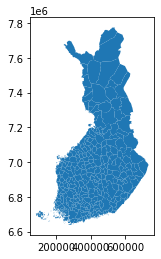

In [13]:
muni_pcrs.plot()

In [14]:
beta = 0.3 * muni_pcrs['area'].mean() ** -0.18
beta

0.08531619877853533

In [15]:
df

,name,out_degree,workers,jobs
0,Akaa,3663,6852,4652
1,Alajärvi,830,3508,3484
2,Alavieska,529,1004,750
3,Alavus,986,4354,4314
4,Asikkala,1547,2988,2254
...,...,...,...,...
290,Ylivieska,1804,6107,6483
291,Ylöjärvi,9514,14456,9316
292,Ypäjä,556,968,625
293,Ähtäri,539,2166,2122


In [16]:
def gravity_exp(df, beta):
    
    def cal_distance(p1, p2):
        x1, y1 = coordinates_book[p1]
        x2, y2 = coordinates_book[p2]
        return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) / 1000 # km

    od = []
    
    for i in range(len(df)):
        for j in range(i + 1, len(df)):

            dist = cal_distance(df.iloc[i]['name'], df.iloc[j]['name'])
                
            flow = df.iloc[i]['workers'] * df.iloc[j]['jobs'] * np.exp(-beta * dist)
            od.append([df.iloc[i]['name'], df.iloc[j]['name'], flow])

            flow = df.iloc[j]['workers'] * df.iloc[i]['jobs'] * np.exp(-beta * dist)
            od.append([df.iloc[j]['name'], df.iloc[i]['name'], flow])

    return od

In [17]:
%%time
fraction = gravity_exp(df, beta)

CPU times: user 51.8 s, sys: 3.33 ms, total: 51.8 s
Wall time: 51.8 s


In [18]:
df_gravity_exp_fraction = pd.DataFrame(fraction, columns=['origin', 'destination', 'fraction'])

In [19]:
df_gravity_exp_fraction['fraction'].sum(), beta

(99218306340.26895, 0.08531619877853533)

In [20]:
df_gravity_exp_fraction

,origin,destination,fraction
0,Akaa,Alajärvi,0.508851
1,Alajärvi,Akaa,0.347852
2,Akaa,Alavieska,0.000001
3,Alavieska,Akaa,0.000001
4,Akaa,Alavus,41.744715
...,...,...,...
86725,Ähtäri,Ypäjä,0.046553
86726,Ypäjä,Äänekoski,0.006534
86727,Äänekoski,Ypäjä,0.004091
86728,Ähtäri,Äänekoski,9913.711306


----
# Production constrained, expected numbers according to conditional probabilities

In [21]:
trips = []
for index, row in df.iterrows():
    
    k = row['out_degree']
    origin = row['name']
    
    select = df_gravity_exp_fraction[df_gravity_exp_fraction['origin'] == origin].copy(True)
    select['weight'] = select['fraction'] / select['fraction'].sum()
    select['flow'] = select['weight'] * k
    
    trips.append(select)

In [22]:
df_od = pd.concat(trips)

In [23]:
df_od

,origin,destination,fraction,weight,flow
0,Akaa,Alajärvi,5.088505e-01,6.441061e-09,2.359361e-05
2,Akaa,Alavieska,1.456654e-06,1.843841e-14,6.753991e-11
4,Akaa,Alavus,4.174472e+01,5.284072e-07,1.935555e-03
6,Akaa,Asikkala,4.276408e+03,5.413103e-05,1.982820e-01
8,Akaa,Askola,3.098230e+02,3.921759e-06,1.436540e-02
...,...,...,...,...,...
86709,Äänekoski,Ylitornio,1.549936e-09,7.913844e-17,1.443485e-13
86717,Äänekoski,Ylivieska,1.778493e+01,9.080837e-07,1.656345e-03
86723,Äänekoski,Ylöjärvi,7.614437e+01,3.887869e-06,7.091472e-03
86727,Äänekoski,Ypäjä,4.090793e-03,2.088725e-10,3.809835e-07


In [24]:
df_od['filtered_flow'] = df_od.flow.apply(lambda z: z if z >= 5 else 0)

In [25]:
df_od['flow'].sum(), df_od['filtered_flow'].sum()

(798356.0, 790706.2907028398)

In [26]:
df_od.head(20)

,origin,destination,fraction,weight,flow,filtered_flow
0,Akaa,Alajärvi,5.088505e-01,6.441061e-09,2.359361e-05,0.000000
2,Akaa,Alavieska,1.456654e-06,1.843841e-14,6.753991e-11,0.000000
4,Akaa,Alavus,4.174472e+01,5.284072e-07,1.935555e-03,0.000000
6,Akaa,Asikkala,4.276408e+03,5.413103e-05,1.982820e-01,0.000000
8,Akaa,Askola,3.098230e+02,3.921759e-06,1.436540e-02,0.000000
10,Akaa,Aura,4.662424e+03,5.901725e-05,2.161802e-01,0.000000
12,Akaa,Enonkoski,3.863906e-05,4.890955e-13,1.791557e-09,0.000000
14,Akaa,Enontekiö,1.745697e-24,2.209714e-32,8.094183e-29,0.000000
16,Akaa,Espoo,3.240198e+04,4.101462e-04,1.502366e+00,0.000000
18,Akaa,Eura,1.344148e+04,1.701431e-04,6.232342e-01,0.000000


In [27]:
df_od.to_csv('results/gravity_model_exp_avg_surface_with_commuter.csv', index=False)

----

In [28]:
from shapely.geometry import Point

In [29]:
df_pop_center = pd.DataFrame([[k, Point(v)] for k, v in coordinates_book.items()], 
                             columns=['name', 'geometry'])

gdf_pop_center = gpd.GeoDataFrame(df_pop_center, geometry='geometry')

In [30]:
gdf_centroid = gpd.GeoDataFrame(muni_pcrs[['tile_ID', 'name', 'centroid']], geometry='centroid')

<AxesSubplot:>

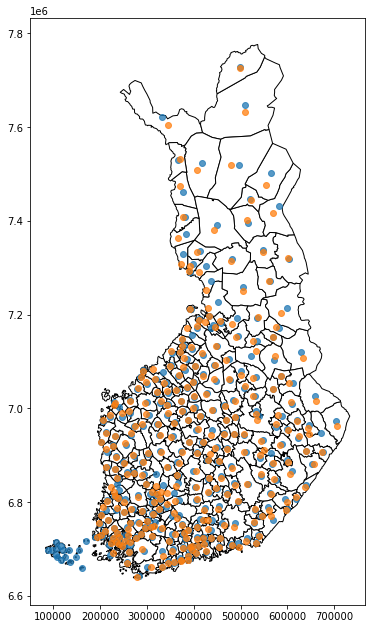

In [31]:
ax = muni_pcrs.plot(figsize=(6, 14), fc='white', ec='k')
gdf_centroid.plot(ax=ax, color='C0', alpha=0.75)
gdf_pop_center.plot(ax=ax, color='C1', alpha=0.75)

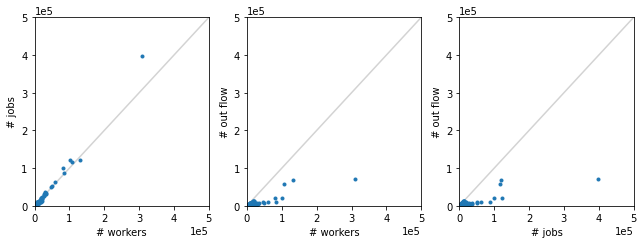

In [32]:
plt.figure(figsize=(9, 3.5))
plt.subplot(1, 3, 1)
plt.plot([0, 5e5], [0, 5e5], color='lightgrey', ls='-')
plt.plot(df.workers, df.jobs, '.')
plt.xlim([0, 5e5])
plt.ylim([0, 5e5])
plt.ticklabel_format(style='sci', axis='both', scilimits=(1,3))
plt.xlabel('# workers')
plt.ylabel('# jobs')

plt.subplot(1, 3, 2)
plt.plot([0, 5e5], [0, 5e5], color='lightgrey', ls='-')
plt.plot(df.workers, df.out_degree, '.')
plt.xlim([0, 5e5])
plt.ylim([0, 5e5])
plt.ticklabel_format(style='sci', axis='both', scilimits=(1,3))
plt.xlabel('# workers')
plt.ylabel('# out flow')

plt.subplot(1, 3, 3)
plt.plot([0, 5e5], [0, 5e5], color='lightgrey', ls='-')
plt.plot(df.jobs, df.out_degree, '.')
plt.xlim([0, 5e5])
plt.ylim([0, 5e5])
plt.ticklabel_format(style='sci', axis='both', scilimits=(1,3))
plt.xlabel('# jobs')
plt.ylabel('# out flow')

plt.tight_layout()

----
# compare gravity to radiation

In [33]:
df_gravity = pd.read_csv('results/gravity_model_exp_avg_surface_with_commuter.csv')
df_radiation = pd.read_csv('results/radiation_model_number_of_commuters_as_prior.csv')

In [46]:
df_gravity_helsinki = df_gravity[df_gravity['origin'] == "Helsinki"] 
df_gravity_helsinki_espoo = df_gravity_helsinki[df_gravity_helsinki['destination'] == "Espoo"] 
df_gravity_helsinki_espoo

,origin,destination,fraction,weight,flow,filtered_flow
7947,Helsinki,Espoo,1.106434e+10,0.373189,26429.253787,26429.253787


In [45]:
df_radiation_helsinki = df_radiation[df_radiation['origin'] == "Helsinki"] 
df_radiation_helsinki_espoo = df_radiation_helsinki[df_radiation_helsinki['destination'] == "Espoo"] 
df_radiation_helsinki_espoo

,origin,destination,workers living in i,jobs in i,jobs in j,jobs in between,estimated_population_flow
8,Helsinki,Espoo,309685,397346,120676,116320,12584.795552


In [34]:
df_merge = df_gravity[['origin', 'destination', 'flow']].merge(df_radiation[['origin', 'destination', 'estimated_population_flow']],
                            on=['origin', 'destination'], how='outer')

In [48]:
df_merge["diff"] =  df_merge["gravity"]-df_merge["radiation"]

In [51]:
df_merge.describe()

,gravity,radiation,diff
count,8.673000e+04,86730.000000,8.673000e+04
mean,9.205073e+00,9.205073,-1.297705e-16
std,3.136106e+02,280.683619,1.309952e+02
min,2.765000e-39,0.000001,-6.353952e+03
25%,1.089087e-11,0.000877,-3.302144e-02
50%,1.641981e-07,0.007222,-2.948095e-03
75%,7.622652e-04,0.076868,-2.698814e-04
max,5.205252e+04,53190.919999,1.806761e+04


In [35]:
df_merge.fillna(0, inplace=True)

In [36]:
df_merge.columns = ['origin', 'destination', 'gravity', 'radiation']

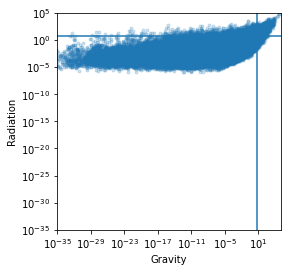

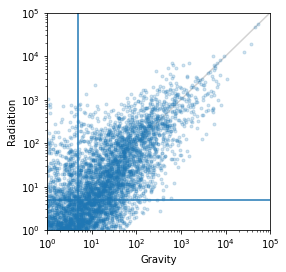

In [37]:
plt.figure(figsize=(4, 4))
plt.plot([5, 1e5], [5, 1e5], '-', color='lightgrey')
plt.loglog(df_merge.gravity, df_merge.radiation, '.', alpha=0.2)
plt.xlabel('Gravity')
plt.ylabel('Radiation')
plt.xlim([1e-35, 1e5])
plt.ylim([1e-35, 1e5])
plt.axhline(5, ls='-')
plt.axvline(5, ls='-')

plt.figure(figsize=(4, 4))
plt.plot([5, 1e5], [5, 1e5], '-', color='lightgrey')
plt.loglog(df_merge.gravity, df_merge.radiation, '.', alpha=0.2)
plt.xlabel('Gravity')
plt.ylabel('Radiation')
plt.xlim([1, 1e5])
plt.ylim([1, 1e5])
plt.axhline(5, ls='-')
plt.axvline(5, ls='-')